# Data Mining 7331 - Fall 2019
## Lab 3 - Collaborative Filtering

* **Allen Ansari**
* **Chad Madding**
* **Yongjun (Ian) Chu**

## Introduction
### Use collaborative filtering to build a custom recommendation system
Different tasks will require different evaluation methods. Be as thorough as possible when analyzing the data you have chosen and use visualizations of the results to explain the performance and expected outcomes whenever possible. Guide the reader through your analysis with plenty of discussion of the results.

### Table of Contents<a id="top"></a>
* **[Business Understanding](#Business_Understanding)**
    * **[10 points]** Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?
* **[Data Understanding - Description](#Data_Understanding_Description)**
    * **[10 points]** Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?
* **[Data Understanding - Visualization](#Data_Understanding_Visualization)**
    * **[10 points]** Visualize any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.
* **[Modeling and Evaluation - Train & Adjust Parameters](#Modeling_and_Evaluation_Train_and_adjust_parameters)**
    * **[10 points]** Create user-item matrices or item-item matrices using collaborative filtering.
* **[Modeling and Evaluation - Evaluate & Compare](#Modeling_and_Evaluation_Evaluate_and_Compare)**
    * **[10 points]** Determine performance of the recommendations using different performance measures and explain what each measure.
* **[Modeling and Evaluation - Visualize Results](#Modeling_and_Evaluation_Visualize_Results)**
    * **[10 points]** Use tables/visualization to discuss the found results. Explain each visualization in detail.
* **[Modeling and Evaluation - Summarize The Ramifications](#Modeling_and_Evaluation_Summarize_The_Ramifications)**
    * **[20 points]** Describe your results. What findings are the most interesting and why?
* **[Deployment](#Deployment)**
    * **[10 points]** Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?
        - How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?
        - How would your deploy your model for interested parties?
        - What other data should be collected?
        - How often would the model need to be updated, etc.?
* **[Exceptional Work](#Exceptional_Work)**
    * **[10 points]** You have free reign to provide additional analyses or combine analyses.

<a href="#top">Back to Top</a>
### Business Understanding<a id="Business Understanding"></a>
* Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?

<a href="#top">Back to Top</a>
### Data Understanding - Description<a id="Data_Understanding_Description"></a>
Recommendation systems are important and valuable tools for companies in **online media business**, to make a personalized experiences for their customers. Each of these companies collects and analyzes demographic data from customers and adds it to information from movie ratings, and user behavior.

These details are then used to predict how customers will rate sets of related items(movie), or how likely a customer is to watch a new movie.

Our dataset (ml-20m) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 20000263 ratings and 465564 tag applications across 27278 movies. These data were created by 138493 users between January 09, 1995 and March 31, 2015. This dataset was generated on March 31, 2015, and updated on October 17, 2016 to update links.csv and add genome-* files.

Users were selected at random for inclusion. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in six files, `genome-scores.csv`, `genome-tags.csv`, `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`. More details about the contents and use of all these files follows.

This and other GroupLens data sets are publicly available for download at <http://grouplens.org/datasets/>.

Formatting and Encoding
-----------------------
The dataset files are written as [comma-separated values](http://en.wikipedia.org/wiki/Comma-separated_values) files with a single header row. Columns that contain commas (`,`) are escaped using double-quotes (`"`). These files are encoded as UTF-8. If accented characters in movie titles or tag values (e.g. Misérables, Les (1995)) display incorrectly, make sure that any program reading the data, such as a text editor, terminal, or script, is configured for UTF-8.

### Imports Of Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import spatial

#enable inline plotting
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import re
import os

### Imports Of Data

In [2]:
print(os.listdir("ml-20m"))

genomescores = pd.read_csv("ml-20m/genome-scores.csv")
genometags = pd.read_csv("ml-20m/genome-tags.csv")
links = pd.read_csv("ml-20m/links.csv")
movies = pd.read_csv("ml-20m/movies.csv")
ratings = pd.read_csv("ml-20m/ratings.csv")
tags = pd.read_csv("ml-20m/tags.csv")

['.gitignore', 'genome-scores.csv', 'genome-tags.csv', 'graphlabDF.csv', 'links.csv', 'mergedDF.csv', 'movies.csv', 'posters', 'ratings.csv', 'README.txt', 'result.csv', 'result1.csv', 'tags.csv']


Movie Ids
---------
Only movies with at least one rating or tag are included in the dataset. These movie ids are consistent with those used on the MovieLens web site (e.g., id `1` corresponds to the URL <https://movielens.org/movies/1>). Movie ids are consistent between `ratings.csv`, `tags.csv`, `movies.csv`, and `links.csv` (i.e., the same id refers to the same movie across these four data files).

User Ids
--------
MovieLens users were selected at random for inclusion. Their ids have been anonymized. User ids are consistent between `ratings.csv` and `tags.csv` (i.e., the same id refers to the same user across the two files).

Tag Genome (genome-scores.csv and genome-tags.csv)
-------------------------------------------------
This data set includes a current copy of the Tag Genome.

[genome-paper]: http://files.grouplens.org/papers/tag_genome.pdf

The tag genome is a data structure that contains tag relevance scores for movies.  The structure is a dense matrix: each movie in the genome has a value for *every* tag in the genome.

As described in [this article][genome-paper], the tag genome encodes how strongly movies exhibit particular properties represented by tags (atmospheric, thought-provoking, realistic, etc.). The tag genome was computed using a machine learning algorithm on user-contributed content including tags, ratings, and textual reviews.

The genome is split into two files.  The file `genome-scores.csv` contains movie-tag relevance data in the following format:

    movieId,tagId,relevance

The second file, `genome-tags.csv`, provides the tag descriptions for the tag IDs in the genome file, in the following format:

    tagId,tag

The `tagId` values are generated when the data set is exported, so they may vary from version to version of the MovieLens data sets.

In [3]:
# Show the dimension and the first 5 rows of the dataset
print(genomescores.shape)
print(type(genomescores))
genomescores.head(5)

(11709768, 3)
<class 'pandas.core.frame.DataFrame'>


,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [4]:
# Show the dimension and the first 5 rows of the dataset
print(genometags.shape)
genometags.head(5)

(1128, 2)


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


Links Data File Structure (links.csv)
---------------------------------------
Identifiers that can be used to link to other sources of movie data are contained in the file `links.csv`. Each line of this file after the header row represents one movie, and has the following format:

    movieId,imdbId,tmdbId

movieId is an identifier for movies used by <https://movielens.org>. E.g., the movie Toy Story has the link <https://movielens.org/movies/1>.

imdbId is an identifier for movies used by <http://www.imdb.com>. E.g., the movie Toy Story has the link <http://www.imdb.com/title/tt0114709/>.

tmdbId is an identifier for movies used by <https://www.themoviedb.org>. E.g., the movie Toy Story has the link <https://www.themoviedb.org/movie/862>.

Use of the resources listed above is subject to the terms of each provider.

In [5]:
# Show the dimension and the first 5 rows of the dataset
print(links.shape)
links.head(5)

(27278, 3)


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


Movies Data File Structure (movies.csv)
---------------------------------------
Movie information is contained in the file `movies.csv`. Each line of this file after the header row represents one movie, and has the following format:

    movieId,title,genres

Movie titles are entered manually or imported from <https://www.themoviedb.org/>, and include the year of release in parentheses. Errors and inconsistencies may exist in these titles.

Genres are a pipe-separated list, and are selected from the following:

* Action
* Adventure
* Animation
* Children's
* Comedy
* Crime
* Documentary
* Drama
* Fantasy
* Film-Noir
* Horror
* Musical
* Mystery
* Romance
* Sci-Fi
* Thriller
* War
* Western
* (no genres listed)

In [6]:
# Show the dimension and the first 5 rows of the dataset
print(movies.shape)
movies.head(5)

(27278, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Ratings Data File Structure (ratings.csv)
-----------------------------------------
All ratings are contained in the file `ratings.csv`. Each line of this file after the header row represents one rating of one movie by one user, and has the following format:

    userId,movieId,rating,timestamp

The lines within this file are ordered first by userId, then, within user, by movieId.

Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).

Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

In [7]:
# Show the dimension and the first 5 rows of the dataset
print(ratings.shape)
ratings.head(5)

(20000263, 4)


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [8]:
del ratings['timestamp']
ratings.describe()

,userId,movieId,rating
count,2.000026e+07,2.000026e+07,2.000026e+07
mean,6.904587e+04,9.041567e+03,3.525529e+00
std,4.003863e+04,1.978948e+04,1.051989e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,3.439500e+04,9.020000e+02,3.000000e+00
50%,6.914100e+04,2.167000e+03,3.500000e+00
75%,1.036370e+05,4.770000e+03,4.000000e+00
max,1.384930e+05,1.312620e+05,5.000000e+00


We can tell that the average rating is 3.52 and the max is 5. We also see that the dataset has 2.000026e+07 records.

Tags Data File Structure (tags.csv)
-----------------------------------
All tags are contained in the file `tags.csv`. Each line of this file after the header row represents one tag applied to one movie by one user, and has the following format:

    userId,movieId,tag,timestamp

The lines within this file are ordered first by userId, then, within user, by movieId.

Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and purpose of a particular tag is determined by each user.

Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

In [9]:
# Show the dimension and the first 5 rows of the dataset
print(tags.shape)
tags.head(5)

(465564, 4)


,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


## Merge Movies, Tags and Ratings Dataframes into mergedDF

##### Remove the timestamp data and create a year column

In [10]:
#for this lab we will not be using the timestamp data

del tags['timestamp']
movies['poster']=movies.apply(lambda x:'ml-20m/posters/%s.jpg' %(x['movieId']), axis=1)
#create year column
movies['year'] = movies['title'].str.extract('.*\((.*)\).*', expand=True)
movies.head()

,movieId,title,genres,poster,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,ml-20m/posters/1.jpg,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,ml-20m/posters/2.jpg,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,ml-20m/posters/3.jpg,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,ml-20m/posters/4.jpg,1995
4,5,Father of the Bride Part II (1995),Comedy,ml-20m/posters/5.jpg,1995


##### Merge movies with tags to get a more full dataset

In [11]:
#merge movies with tags to get a more full dataset
movies_tag = movies.merge(tags, on='movieId', how='inner')
movies_tag.head()

,movieId,title,genres,poster,year,userId,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,ml-20m/posters/1.jpg,1995,1644,Watched
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,ml-20m/posters/1.jpg,1995,1741,computer animation
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,ml-20m/posters/1.jpg,1995,1741,Disney animated feature
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,ml-20m/posters/1.jpg,1995,1741,Pixar animation
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,ml-20m/posters/1.jpg,1995,1741,TÃ©a Leoni does not star in this movie


In [12]:
# then merge movies_tag and rating data
mergedDF = pd.merge(movies_tag,ratings)
# now lets look at our data
mergedDF.head(10)

,movieId,title,genres,poster,year,userId,tag,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,ml-20m/posters/1.jpg,1995,1644,Watched,3.5
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,ml-20m/posters/1.jpg,1995,1741,computer animation,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,ml-20m/posters/1.jpg,1995,1741,Disney animated feature,4.0
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,ml-20m/posters/1.jpg,1995,1741,Pixar animation,4.0
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,ml-20m/posters/1.jpg,1995,1741,TÃ©a Leoni does not star in this movie,4.0
5,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,ml-20m/posters/1.jpg,1995,2299,Pixar,3.0
6,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,ml-20m/posters/1.jpg,1995,3596,animation,1.0
7,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,ml-20m/posters/1.jpg,1995,3596,family,1.0
8,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,ml-20m/posters/1.jpg,1995,3596,Tom Hanks,1.0
9,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,ml-20m/posters/1.jpg,1995,6233,Pixar,4.5


In [13]:
mergedDF.describe()

,movieId,userId,rating
count,391445.000000,391445.000000,391445.000000
mean,32766.306189,67291.897587,3.780652
std,35997.920748,42227.513945,1.024136
min,1.000000,65.000000,0.500000
25%,2502.000000,27898.000000,3.000000
50%,7361.000000,66635.000000,4.000000
75%,63072.000000,106755.000000,4.500000
max,131258.000000,138472.000000,5.000000


In [14]:
#count the number of movies in each genres
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue
        for s in liste_keywords: 
            if pd.notnull(s): keyword_count[s] += 1
    # convert the dictionary in a list to sort the keywords  by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [15]:
#we can see all of the genres
genre_labels = set()
for s in mergedDF['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

In [16]:
#counting how many times each of genres occur:
keyword_occurences, dum = count_word(mergedDF, 'genres', genre_labels)
keyword_occurences

[['Drama', 200635],
 ['Comedy', 118912],
 ['Thriller', 115062],
 ['Action', 107325],
 ['Sci-Fi', 78375],
 ['Adventure', 77199],
 ['Romance', 68338],
 ['Crime', 68294],
 ['Fantasy', 46217],
 ['Mystery', 42494],
 ['Horror', 36259],
 ['IMAX', 24988],
 ['Animation', 23644],
 ['Children', 20552],
 ['War', 19584],
 ['Musical', 13097],
 ['Documentary', 9032],
 ['Film-Noir', 5888],
 ['Western', 5607],
 ['(no genres listed)', 46]]

### Looking at what movies got the most ratings

In [17]:
#Group by the movir id and the ratings
mergedDF.groupby('title')['rating'].count().sort_values(ascending=False).head(10)

title
Pulp Fiction (1994)                             1953
Fight Club (1999)                               1702
Inception (2010)                                1525
Matrix, The (1999)                              1406
Shawshank Redemption, The (1994)                1302
Eternal Sunshine of the Spotless Mind (2004)    1204
Memento (2000)                                  1155
Donnie Darko (2001)                             1144
Silence of the Lambs, The (1991)                1069
Forrest Gump (1994)                              978
Name: rating, dtype: int64

<a href="#top">Back to Top</a>
### Data Understanding - Visualization<a id="Data_Understanding_Visualization"></a>
* Visualize any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

For using Graphlab package we just need all data with 'userId', 'movieId', 'rating'

In [18]:
result = pd.merge(movies,
                 ratings[['userId', 'movieId', 'rating']],
                 on='movieId')
result= result[["userId", "title", "rating"]]
print(result.head())
print(result.info())

#Export our data set to use for GraphLab
result.to_csv(r'ml-20m\result.csv', index = None, header=True)

   userId             title  rating
0       3  Toy Story (1995)     4.0
1       6  Toy Story (1995)     5.0
2       8  Toy Story (1995)     4.0
3      10  Toy Story (1995)     4.0
4      11  Toy Story (1995)     4.5
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000263 entries, 0 to 20000262
Data columns (total 3 columns):
userId    int64
title     object
rating    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 610.4+ MB
None


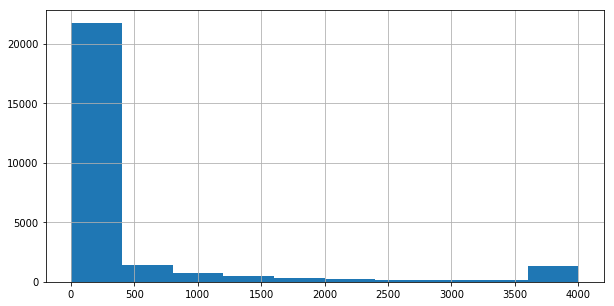

In [19]:
#looking at the rating per movieid
ratings_movie= result.groupby('title')['rating'].count().clip(upper=4000)
ratings_movie.hist(figsize=(10,5))

In [20]:
result.groupby('title')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,title,rating
18825,Pulp Fiction (1994),67310
8717,Forrest Gump (1994),66172
20780,"Shawshank Redemption, The (1994)",63366
20995,"Silence of the Lambs, The (1991)",63299
12646,Jurassic Park (1993),59715
21872,Star Wars: Episode IV - A New Hope (1977),54502
3507,Braveheart (1995),53769
22984,Terminator 2: Judgment Day (1991),52244
15187,"Matrix, The (1999)",51334
20318,Schindler's List (1993),50054


Most of the movies in the data received less than 10 ratings, and very few movies have many ratings, although the most rated book has received 68721 ratings.

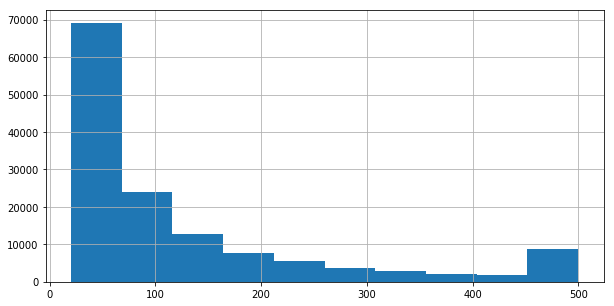

In [21]:
#looking at the rating per movieid
ratings_user= result.groupby('userId')['rating'].count().clip(upper=500)
ratings_user.hist(figsize=(10,5))

In [22]:
 result.groupby('userId')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,userId,rating
118204,118205,9254
8404,8405,7515
82417,82418,5646
121534,121535,5520
125793,125794,5491
74141,74142,5447
34575,34576,5356
131903,131904,5330
83089,83090,5169
59476,59477,4988


In [23]:
 result.groupby('userId')['rating'].count().reset_index().sort_values('rating', ascending=True)[:10]

,userId,rating
39573,39574,20
61691,61692,20
20577,20578,20
68138,68139,20
21881,21882,20
41287,41288,20
120163,120164,20
68122,68123,20
50577,50578,20
108564,108565,20


minimum rating that users have given is 20 and the most productive user have given 9158 ratings.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C217688>]],
      dtype=object)

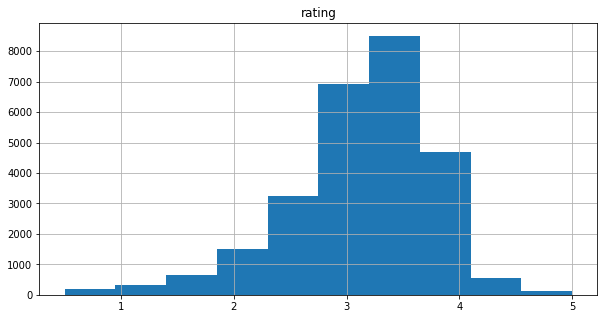

In [24]:
#looking at the rating averages
avg_ratings= result.groupby('title', as_index=False).mean()

avg_ratings.hist(column='rating', figsize=(10,5))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001ED02B08>]],
      dtype=object)

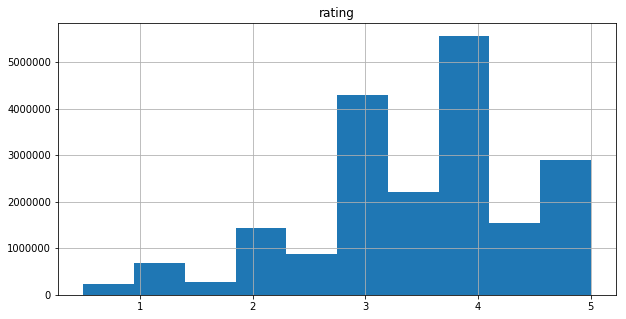

In [25]:
#looking at the distribution of the ratings
result.hist(column='rating', figsize=(10,5))

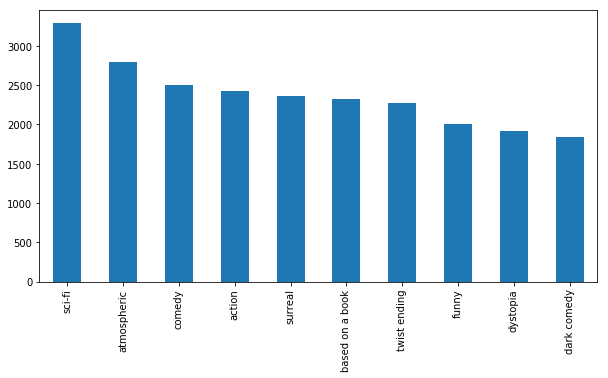

In [26]:
#looking at the top 10 tags
tag_counts = mergedDF['tag'].value_counts()
tag_counts[:10].plot(kind='bar', figsize=(10,5))

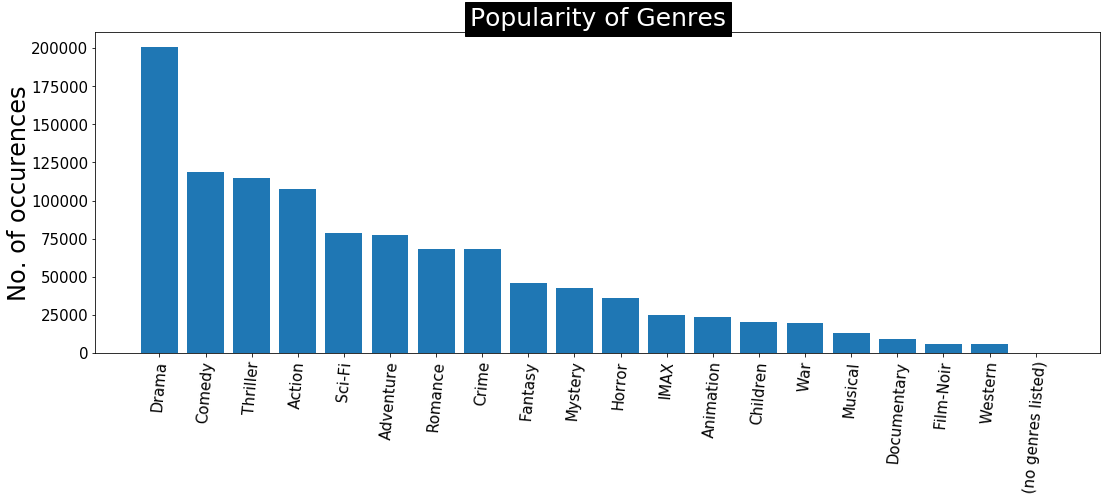

In [27]:
#Graph the Genres vs Occurrences
#https://github.com/nareshkumar66675/MovieLens/blob/master/notebooks/MovieLens.ipynb
fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in keyword_occurences]
x_axis = [k for k,i in enumerate(keyword_occurences)]
x_label = [i[0] for i in keyword_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("No. of occurences", fontsize = 24, labelpad = 0)
ax2.bar(x_axis, y_axis, align = 'center')
plt.title("Popularity of Genres",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 25)
plt.show()

In [28]:
result.describe()

,userId,rating
count,2.000026e+07,2.000026e+07
mean,6.904587e+04,3.525529e+00
std,4.003863e+04,1.051989e+00
min,1.000000e+00,5.000000e-01
25%,3.439500e+04,3.000000e+00
50%,6.914100e+04,3.500000e+00
75%,1.036370e+05,4.000000e+00
max,1.384930e+05,5.000000e+00


<a href="#top">Back to Top</a>
### Modeling and Evaluation - Train & Adjust Parameters<a id="Modeling_and_Evaluation_Train_and_adjust_parameters"></a>
* Create user-item matrices or item-item matrices using collaborative filtering.

We will be using a user-item matrices for our recommendation system. The utility matrices will be sparse due to the fact that every user did not review every movie. So in the data we are more likely to see mostly null values. 

We will use matrix factorization to build recommender systems. Specifically, we will use item_similarity and ranking_factorization recommenders from GraphLab Create. First, we would like to find the best parameter setting for each recommender.

In [29]:
# Import Graphlab and load the data file to build a recommendation system

import graphlab as gl

data = gl.SFrame.read_csv("ml-20m/result.csv", 
                          column_type_hints={"rating":float})

This non-commercial license of GraphLab Create for academic use is assigned to cmadding@smu.edu and will expire on November 18, 2020.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\04616598\AppData\Local\Temp\graphlab_server_1574869927.log.0


Finished parsing file C:\Users\04616598\BSync\Box Sync\Documents\Data Sciance\msds_7331MachineLearningI\MSDS7331\Lab03\ml-20m\result.csv

Parsing completed. Parsed 100 lines in 0.681226 secs.

Read 1528914 lines. Lines per second: 2.41041e+006

Finished parsing file C:\Users\04616598\BSync\Box Sync\Documents\Data Sciance\msds_7331MachineLearningI\MSDS7331\Lab03\ml-20m\result.csv

Parsing completed. Parsed 20000263 lines in 4.94278 secs.

In [30]:
#generate a train and a test sub-datasets for parameter tuning and performance comparison
train, test = gl.recommender.util.random_split_by_user(data, random_seed = 75205,
                                                    user_id="userId", item_id="title",
                                                    max_num_users=100, item_test_proportion=0.2)

In [31]:
print(test)

+--------+-------------------------------+--------+
| userId |             title             | rating |
+--------+-------------------------------+--------+
| 29110  |        Toy Story (1995)       |  5.0   |
| 75676  |        Toy Story (1995)       |  5.0   |
| 115585 |        Toy Story (1995)       |  4.0   |
| 118929 |        Toy Story (1995)       |  4.0   |
| 120813 |        Toy Story (1995)       |  4.0   |
| 49190  |         Jumanji (1995)        |  3.0   |
| 63232  |         Jumanji (1995)        |  2.5   |
| 104017 |    Grumpier Old Men (1995)    |  1.5   |
| 104017 |    Waiting to Exhale (1995)   |  1.5   |
| 37402  | Father of the Bride Part I... |  3.0   |
+--------+-------------------------------+--------+
[2512 rows x 3 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


#### Find the best parameters for item_similarity recommender

The graphlab method, "model_paramter_search", doesn't support the item_similarity_recommender currently.
We have to manually find the best parameters. There are essentially only two parameters that may need to be optimized: only_top_k and similarity_type. Since our user_item matrix obtained is sparse, choosing "cosine" is the best choice. Therefore, we only need to optimize the values for only_top_k. Here we are to find which one gives the best validation results among 5 values: 5,10,15,20,25. The default value is 64. However, bigger value will require significantly more computational power. We feel like that choosing 5 to 25 is a reasonable range.    

In [32]:
#find the best parameter for only_top_k
from IPython.display import display
from IPython.display import Image

gl.canvas.set_target('ipynb')

top_k = [5,10,15,20,25]
item_item = []

for i in range(len(top_k)):
    item_simi = gl.recommender.item_similarity_recommender.create(train, 
                                  user_id="userId", 
                                  item_id="title", 
                                  target="rating",
                                  only_top_k= top_k[i],
                                  similarity_type="cosine")
    
    item_item.append(item_simi)

Recsys training: model = item_similarity

Preparing data set.

Data has 19997751 observations with 138493 users and 26729 items.

Data prepared in: 9.61721s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 18.948ms                       | 0.5        |

| 162.573ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1.33s                               | 0                | 0               |

| 2.33s                               | 2.5              | 715             |

| 3.34s                               | 5.75             | 1563            |

| 4.33s                               | 8.75             | 2351            |

| 5.33s                               | 11.5             | 3122            |

| 6.33s                               | 14.5             | 3896            |

| 7.33s                               | 17.25            | 4676            |

| 8.33s                               | 20.25            | 5467            |

| 9.33s                               | 23.25            | 6235            |

| 10.33s                              | 26.25            | 7049            |

| 11.33s                              | 29.75            | 7954            |

| 12.33s                              | 32.75            | 8819            |

| 13.33s                              | 36.25            | 9740            |

| 14.33s                              | 39.75            | 10687           |

| 15.33s                              | 43.75            | 11730           |

| 16.33s                              | 47               | 12570           |

| 17.33s                              | 50               | 13408           |

| 18.33s                              | 53.5             | 14355           |

| 19.33s                              | 56.25            | 15068           |

| 20.33s                              | 59.25            | 15848           |

| 21.33s                              | 62.25            | 16650           |

| 22.33s                              | 65               | 17399           |

| 23.33s                              | 67.75            | 18125           |

| 24.33s                              | 70.5             | 18895           |

| 25.33s                              | 73.25            | 19637           |

| 26.33s                              | 76.25            | 20413           |

| 27.33s                              | 78.75            | 21100           |

| 28.33s                              | 81.25            | 21770           |

| 29.33s                              | 83.75            | 22450           |

| 30.33s                              | 86.25            | 23110           |

| 31.33s                              | 88.75            | 23750           |

| 32.33s                              | 91               | 24364           |

| 33.33s                              | 93.25            | 24969           |

| 34.33s                              | 95.5             | 25559           |

| 35.33s                              | 97.75            | 26172           |

| 37.83s                              | 100              | 26729           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 39.3164s

Recsys training: model = item_similarity

Preparing data set.

Data has 19997751 observations with 138493 users and 26729 items.

Data prepared in: 9.05572s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.996ms                        | 0.5        |

| 154.586ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 931.504ms                           | 0                | 0               |

| 1.93s                               | 2.75             | 788             |

| 2.93s                               | 6.25             | 1677            |

| 3.93s                               | 9                | 2471            |

| 4.93s                               | 12               | 3273            |

| 5.93s                               | 15.25            | 4094            |

| 6.93s                               | 18.25            | 4890            |

| 7.92s                               | 21.25            | 5729            |

| 8.93s                               | 24               | 6455            |

| 9.93s                               | 27               | 7236            |

| 10.92s                              | 30.5             | 8162            |

| 11.93s                              | 34.25            | 9160            |

| 12.93s                              | 37.5             | 10046           |

| 13.93s                              | 41               | 10966           |

| 14.93s                              | 44.25            | 11872           |

| 15.93s                              | 48               | 12870           |

| 16.92s                              | 51.25            | 13747           |

| 17.92s                              | 54.75            | 14655           |

| 18.92s                              | 57.5             | 15434           |

| 19.92s                              | 60.25            | 16151           |

| 20.92s                              | 63               | 16847           |

| 21.92s                              | 66.25            | 17727           |

| 22.92s                              | 69               | 18465           |

| 23.92s                              | 71.75            | 19222           |

| 24.92s                              | 74.5             | 19977           |

| 25.92s                              | 77.25            | 20664           |

| 26.92s                              | 79.75            | 21346           |

| 27.92s                              | 82.5             | 22079           |

| 28.92s                              | 85               | 22783           |

| 29.92s                              | 87.5             | 23428           |

| 30.92s                              | 90               | 24087           |

| 31.92s                              | 92.25            | 24715           |

| 32.92s                              | 94.75            | 25331           |

| 33.92s                              | 97               | 25953           |

| 34.92s                              | 99.25            | 26562           |

| 36.78s                              | 100              | 26729           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 37.1803s

Recsys training: model = item_similarity

Preparing data set.

Data has 19997751 observations with 138493 users and 26729 items.

Data prepared in: 9.96827s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.982ms                        | 0.5        |

| 161.554ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 967.394ms                           | 0                | 0               |

| 1.96s                               | 2.5              | 721             |

| 2.96s                               | 5.5              | 1508            |

| 3.96s                               | 8                | 2169            |

| 4.96s                               | 10.75            | 2910            |

| 5.96s                               | 13.75            | 3684            |

| 6.96s                               | 16.25            | 4404            |

| 7.96s                               | 19               | 5131            |

| 8.96s                               | 21.75            | 5873            |

| 9.96s                               | 24.25            | 6516            |

| 10.97s                              | 27.25            | 7299            |

| 11.96s                              | 30.25            | 8092            |

| 12.96s                              | 33               | 8864            |

| 13.96s                              | 36               | 9641            |

| 14.96s                              | 39.5             | 10563           |

| 15.96s                              | 42.5             | 11407           |

| 16.96s                              | 46               | 12310           |

| 17.96s                              | 49.25            | 13220           |

| 18.96s                              | 52.75            | 14155           |

| 19.96s                              | 55.75            | 14962           |

| 20.96s                              | 58.75            | 15737           |

| 21.96s                              | 61.5             | 16482           |

| 22.96s                              | 64.5             | 17254           |

| 23.96s                              | 67.25            | 17976           |

| 24.96s                              | 69.75            | 18678           |

| 25.96s                              | 72.75            | 19452           |

| 26.96s                              | 75.5             | 20226           |

| 27.96s                              | 78.25            | 20981           |

| 28.96s                              | 81               | 21714           |

| 29.96s                              | 83.75            | 22390           |

| 30.96s                              | 86.25            | 23063           |

| 31.96s                              | 88.5             | 23711           |

| 32.96s                              | 91               | 24332           |

| 33.96s                              | 93               | 24917           |

| 34.96s                              | 95.25            | 25465           |

| 35.96s                              | 96.75            | 25884           |

| 36.96s                              | 98.75            | 26407           |

| 39.51s                              | 100              | 26729           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 40.1321s

Recsys training: model = item_similarity

Preparing data set.

Data has 19997751 observations with 138493 users and 26729 items.

Data prepared in: 10.3744s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.996ms                        | 0.5        |

| 171.849ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1.03s                               | 0                | 0               |

| 2.03s                               | 2.5              | 715             |

| 3.04s                               | 5.5              | 1487            |

| 4.03s                               | 8                | 2144            |

| 5.03s                               | 10.5             | 2811            |

| 6.03s                               | 13               | 3529            |

| 7.03s                               | 15.75            | 4215            |

| 8.03s                               | 18.25            | 4933            |

| 9.03s                               | 21               | 5629            |

| 10.03s                              | 23.25            | 6260            |

| 11.04s                              | 25.75            | 6933            |

| 12.03s                              | 28.5             | 7666            |

| 13.03s                              | 31.25            | 8402            |

| 14.03s                              | 34.5             | 9272            |

| 15.02s                              | 37.5             | 10043           |

| 16.03s                              | 40.25            | 10812           |

| 17.02s                              | 43.25            | 11575           |

| 18.02s                              | 46.5             | 12464           |

| 19.02s                              | 49.25            | 13218           |

| 20.03s                              | 52.5             | 14034           |

| 21.02s                              | 55               | 14760           |

| 22.02s                              | 57.75            | 15443           |

| 23.02s                              | 60               | 16043           |

| 24.02s                              | 62.25            | 16654           |

| 25.02s                              | 64.75            | 17353           |

| 26.02s                              | 67.25            | 17983           |

| 27.02s                              | 69.25            | 18556           |

| 28.02s                              | 71.75            | 19182           |

| 29.02s                              | 74.25            | 19851           |

| 30.02s                              | 76.75            | 20517           |

| 31.02s                              | 79               | 21171           |

| 32.02s                              | 81.75            | 21854           |

| 33.02s                              | 84               | 22499           |

| 34.02s                              | 86.5             | 23174           |

| 35.02s                              | 89               | 23814           |

| 36.02s                              | 91.25            | 24410           |

| 37.02s                              | 93.5             | 24998           |

| 38.02s                              | 95.5             | 25578           |

| 39.02s                              | 97.75            | 26147           |

| 40.02s                              | 99.5             | 26637           |

| 41.94s                              | 100              | 26729           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 42.4844s

Recsys training: model = item_similarity

Preparing data set.

Data has 19997751 observations with 138493 users and 26729 items.

Data prepared in: 10.2841s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 2.024ms                        | 0.5        |

| 156.96ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 971.209ms                           | 0                | 0               |

| 1.97s                               | 2.75             | 761             |

| 2.97s                               | 5.75             | 1602            |

| 3.97s                               | 8.75             | 2361            |

| 4.97s                               | 11.5             | 3121            |

| 5.97s                               | 14.25            | 3862            |

| 6.97s                               | 17.25            | 4628            |

| 7.97s                               | 20               | 5358            |

| 8.97s                               | 22.75            | 6129            |

| 9.97s                               | 25.5             | 6861            |

| 10.96s                              | 28.5             | 7681            |

| 11.97s                              | 31.5             | 8446            |

| 12.96s                              | 34.75            | 9304            |

| 13.96s                              | 38               | 10194           |

| 14.97s                              | 41.25            | 11027           |

| 15.96s                              | 44               | 11773           |

| 16.96s                              | 47.25            | 12679           |

| 17.96s                              | 50.75            | 13586           |

| 18.97s                              | 53.75            | 14398           |

| 19.96s                              | 56.75            | 15170           |

| 20.96s                              | 59.5             | 15918           |

| 21.96s                              | 62.25            | 16691           |

| 22.96s                              | 65               | 17428           |

| 23.96s                              | 67.75            | 18116           |

| 24.96s                              | 70.5             | 18888           |

| 25.96s                              | 73               | 19559           |

| 26.96s                              | 75.5             | 20243           |

| 27.96s                              | 78.25            | 20980           |

| 28.96s                              | 81               | 21694           |

| 29.96s                              | 83.25            | 22316           |

| 30.96s                              | 85.75            | 22937           |

| 31.96s                              | 88               | 23565           |

| 32.96s                              | 90.25            | 24187           |

| 33.96s                              | 92.5             | 24770           |

| 34.96s                              | 94.5             | 25311           |

| 35.96s                              | 96.75            | 25881           |

| 36.96s                              | 99               | 26461           |

| 39.21s                              | 100              | 26729           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 39.6539s

We want to compare which model gives the best perfromance overall. So we decided to use graphlab compare( ) method for comparison.

In [33]:
comparisonstruct = gl.compare(test,item_item)

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.42      | 0.0281205111405 |
|   2    |      0.38      | 0.0533654490354 |
|   3    | 0.383333333333 | 0.0792510595951 |
|   4    |     0.3525     |  0.101588976168 |
|   5    |      0.34      |  0.116841188211 |
|   6    |     0.325      |  0.134145298892 |
|   7    | 0.311428571429 |  0.14438955093  |
|   8    |     0.2975     |  0.154988316387 |
|   9    | 0.291111111111 |  0.167621235043 |
|   10   |     0.284      |  0.177229822645 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model M1

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.41      | 0.0383999

We want to compare which model gives the best performance overall. 

In [34]:
gl.show_comparison(comparisonstruct,item_item)

From the above graph, it is clear that all five models performed equally well based on the overall precision and recall values for all 18 cutoff values chosen. Since with only_top_k equal to 5 requires the least memory and computation time, we chose "only_top_k = 5" for all the following item_similarity recommender. 

#### Find the best parameters for ranking_factorization recommender

A RankingFactorizationRecommender learns latent factors for each user and item and uses them to rank recommended items according to the likelihood of observing those (user, item) pairs. This is commonly desired when performing collaborative filtering for implicit feedback datasets or datasets with explicit ratings for which ranking prediction is desired.

RankingFactorizationRecommender contains a number of options that tailor to a variety of datasets and evaluation metrics, making this one of the most powerful models in the GraphLab Create recommender toolkit.

In [35]:
#optimize parameters to find the best model parameters
params = {'user_id': 'userId', 
          'item_id': 'title', 
          'target': 'rating',
          'num_factors': [8, 12, 16, 24, 32], 
          'regularization':[0.001] ,
          'linear_regularization': [0.001]}

job = gl.model_parameter_search.create( (train,test),
        gl.recommender.ranking_factorization_recommender.create,
        params,
        max_models=5,
        environment=None)

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.job: Creating a LocalAsync environment called 'async'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Nov-27-2019-09-56-4700000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Nov-27-2019-09-56-4700000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-Nov-27-2019-09-56-4700000' already exists. Renaming the job to 'Model-Parameter-Search-Nov-27-2019-09-56-4700000-0aed4'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Nov-27-2019-09-56-4700000-0aed4' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Nov-27-2019-09-56-4700000-0aed4' scheduled.


In [36]:
job.get_status()

{'Canceled': 0, 'Completed': 0, 'Failed': 0, 'Pending': 5, 'Running': 0}

In [37]:
job_result = job.get_results()

job_result.head()

model_id,item_id,linear_regularization,max_iterations,num_factors,num_sampled_negative_examples ...,ranking_regularization
1,title,0.001,25,8,8,0.1
0,title,0.001,50,8,8,0.25
3,title,0.001,25,24,4,0.25
2,title,0.001,25,24,8,0.5
4,title,0.001,25,12,4,0.1
regularization,target,user_id,training_precision@5,training_recall@5,training_rmse,validation_precision@5
0.001,rating,userId,0.388517831226,0.023685956787,0.986021545219,0.176
0.001,rating,userId,0.388517831226,0.023685956787,0.990522867648,0.176
0.001,rating,userId,0.388517831226,0.023685956787,0.986313878627,0.176
0.001,rating,userId,0.388517831226,0.023685956787,0.997857209079,0.176


In [38]:
bst_prms = job.get_best_params()
bst_prms

{'item_id': 'title',
 'linear_regularization': 0.001,
 'max_iterations': 25,
 'num_factors': 12,
 'num_sampled_negative_examples': 4,
 'ranking_regularization': 0.1,
 'regularization': 0.001,
 'target': 'rating',
 'user_id': 'userId'}

In [39]:
models = job.get_models()
models

[Class                            : RankingFactorizationRecommender
 
 Schema
 ------
 User ID                          : userId
 Item ID                          : title
 Target                           : rating
 Additional observation features  : 0
 User side features               : []
 Item side features               : []
 
 Statistics
 ----------
 Number of observations           : 19997751
 Number of users                  : 138493
 Number of items                  : 26729
 
 Training summary
 ----------------
 Training time                    : 183.6356
 
 Model Parameters
 ----------------
 Model class                      : RankingFactorizationRecommender
 num_factors                      : 8
 binary_target                    : 0
 side_data_factorization          : 1
 solver                           : auto
 nmf                              : 0
 max_iterations                   : 50
 
 Regularization Settings
 -----------------------
 regularization                   : 0.001

In [40]:
comparisonstruct = gl.compare(test,models)
gl.show_comparison(comparisonstruct,models)

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.23      | 0.0100477230193 |
|   2    |      0.2       | 0.0178956829317 |
|   3    | 0.196666666667 | 0.0265961090077 |
|   4    |     0.195      | 0.0328187876057 |
|   5    |     0.176      | 0.0362479412494 |
|   6    |      0.17      |  0.040778311777 |
|   7    | 0.162857142857 | 0.0475946176345 |
|   8    |    0.15125     | 0.0495806917651 |
|   9    | 0.137777777778 | 0.0502509851174 |
|   10   |     0.132      | 0.0568393515077 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model M1

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.23      | 0.0100477

From the above graph, it appears that all five models performed equally well based on the overall precision and recall values for all cutoff values chosen. We chose to use the best parameters obtained above for the ranking_factorization_recommender in the following sections. 

<a href="#top">Back to Top</a>
### Modeling and Evaluation - Evaluate & Compare<a id="Modeling_and_Evaluation_Evaluate_and_Compare"></a>
* Determine performance of the recommendations using different performance measures and explain what each measure.

#### Evaluate item_similarity recommender using the optimal parameter settings

In [41]:
from IPython.display import display
from IPython.display import Image

gl.canvas.set_target('ipynb')

item_item = gl.recommender.item_similarity_recommender.create(train, 
                                  user_id="userId", 
                                  item_id="title", 
                                  target="rating",
                                  only_top_k= 5,
                                  similarity_type="cosine")
    
rmse_results = item_item.evaluate(test)

Recsys training: model = item_similarity

Preparing data set.

Data has 19997751 observations with 138493 users and 26729 items.

Data prepared in: 8.83332s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 2.991ms                        | 0.5        |

| 146.606ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1.04s                               | 0                | 0               |

| 2.04s                               | 2.75             | 767             |

| 3.04s                               | 6                | 1611            |

| 4.04s                               | 8.75             | 2369            |

| 5.05s                               | 11.75            | 3171            |

| 6.04s                               | 14.5             | 3918            |

| 7.04s                               | 17.5             | 4712            |

| 8.04s                               | 20.25            | 5479            |

| 9.04s                               | 23               | 6207            |

| 10.04s                              | 25.75            | 6924            |

| 11.04s                              | 28.75            | 7718            |

| 12.04s                              | 32.25            | 8678            |

| 13.05s                              | 36               | 9623            |

| 14.04s                              | 38.75            | 10407           |

| 15.04s                              | 41.75            | 11214           |

| 16.04s                              | 45               | 12058           |

| 17.04s                              | 48.25            | 12945           |

| 18.04s                              | 51.75            | 13845           |

| 19.04s                              | 55.25            | 14808           |

| 20.04s                              | 58.75            | 15703           |

| 21.04s                              | 61.25            | 16380           |

| 22.04s                              | 63.75            | 17072           |

| 23.04s                              | 66.5             | 17822           |

| 24.04s                              | 69.25            | 18563           |

| 25.04s                              | 72               | 19307           |

| 26.04s                              | 74.75            | 20029           |

| 27.04s                              | 77.5             | 20730           |

| 28.04s                              | 79.75            | 21343           |

| 29.04s                              | 82               | 21944           |

| 30.04s                              | 84.25            | 22570           |

| 31.04s                              | 86.75            | 23230           |

| 32.04s                              | 89               | 23821           |

| 33.04s                              | 91               | 24371           |

| 34.04s                              | 93.25            | 24944           |

| 35.04s                              | 95               | 25444           |

| 36.04s                              | 97.25            | 26052           |

| 37.04s                              | 99.5             | 26646           |

| 38.80s                              | 100              | 26729           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 39.3113s


Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.42      | 0.0281205111405 |
|   2    |     0.375      | 0.0530206214492 |
|   3    | 0.383333333333 | 0.0793205040395 |
|   4    |      0.35      |  0.100160404739 |
|   5    |     0.338      |  0.115412616782 |
|   6    | 0.323333333333 |  0.132716727463 |
|   7    |      0.31      |  0.142960979501 |
|   8    |    0.29625     |  0.153559744959 |
|   9    |      0.29      |  0.166192663614 |
|   10   |     0.283      |  0.175801251216 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 3.6452071330063665)

Per User RMSE (best)
+--------+-------+---------------+
| userId | count |      rmse     |
+--------+-------+---------------+
| 100197 |   4   | 2.06026246036 |
+--------+-------+---------------+
[1 rows x 3 columns]


Per User RMSE (worst)

In [42]:
print rmse_results.viewkeys()

dict_keys(['rmse_by_user', 'precision_recall_overall', 'rmse_by_item', 'precision_recall_by_user', 'rmse_overall'])


In [43]:
rmse_results['rmse_by_user']

userId,count,rmse
100197,4,2.06026246036
4414,8,3.14696377527
132030,13,4.27855969192
102179,10,3.1938265945
29110,12,3.879442265
120458,193,3.72132954592
60041,8,3.5881750236
17734,32,3.76217558901
118929,8,3.64119987104
6105,7,4.15458177393


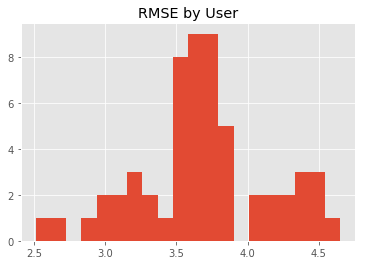

In [44]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

rmsevals = rmse_results['rmse_by_user']['rmse']
rmsevals = rmsevals[rmse_results['rmse_by_user']['count']>10]

plt.hist(rmsevals,bins=20)
plt.title('RMSE by User')
plt.show()

In [45]:
rmse_results['precision_recall_by_user']

userId,cutoff,precision,recall,count
3014,1,0.0,0.0,10
3014,2,0.0,0.0,10
3014,3,0.0,0.0,10
3014,4,0.0,0.0,10
3014,5,0.0,0.0,10
3014,6,0.166666666667,0.1,10
3014,7,0.142857142857,0.1,10
3014,8,0.125,0.1,10
3014,9,0.111111111111,0.1,10
3014,10,0.2,0.2,10


In [46]:
import graphlab.aggregate as agg

# we will be using these aggregations
agg_list = [agg.AVG('precision'),agg.STD('precision'),agg.AVG('recall'),agg.STD('recall')]

# apply these functions to each group (we will group the results by 'k' which is the cutoff)
# the cutoff is the number of top items to look for see the following URL for the actual equation
# https://dato.com/products/create/docs/generated/graphlab.recommender.util.precision_recall_by_user.html#graphlab.recommender.util.precision_recall_by_user
rmse_results['precision_recall_by_user'].groupby('cutoff',agg_list)


cutoff,Avg of precision,Stdv of precision,Avg of recall,Stdv of recall
16,0.250625,0.208134384173,0.235869593764,0.198875164545
10,0.283,0.247812429067,0.175801251216,0.181543431794
36,0.173333333333,0.161595058597,0.332410883416,0.225288032066
26,0.201153846154,0.175399375222,0.29434164201,0.219264118894
41,0.16512195122,0.15517467274,0.357637159347,0.225429107958
3,0.383333333333,0.334580998331,0.0793205040395,0.101411815226
1,0.42,0.49355850717,0.0281205111405,0.0517031325068
6,0.323333333333,0.270616579931,0.132716727463,0.157087356595
11,0.278181818182,0.23560016557,0.189259603033,0.185229244098
2,0.375,0.402336923486,0.0530206214492,0.0861472947071


#### Evaluate ranking_factorization recommender 

We use the best parameters obtained above for the following ranking_factorization_recommender. 

In [47]:
rec1 = gl.recommender.ranking_factorization_recommender.create(train, 
                                  user_id="userId", 
                                  item_id="title", 
                                  target="rating",
                                  num_factors=12,                 # override the default value
                                  regularization=1e-03,           # override the default value
                                  linear_regularization = 1e-3,   # override the default value
                                  ranking_regularization = 0.1,   # override the default value
                                  num_sampled_negative_examples = 4, # override the default value
                                  max_iterations = 50   )   # override the default value

rmse_results = rec1.evaluate(test)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 19997751 observations with 138493 users and 26729 items.

Data prepared in: 9.63817s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 12       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.1      |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 2499718 / 19997751 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.00368454        | Not Viable                               |

| 1       | 0.000921136       | 1.48859                                  |

| 2       | 0.000460568       | 1.4773                                   |

| 3       | 0.000230284       | 1.46955                                  |

| 4       | 0.000115142       | 1.46779                                  |

| 5       | 5.7571e-005       | 1.4714                                   |

| 6       | 2.87855e-005      | 1.47983                                  |

| 7       | 1.43927e-005      | 1.49557                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.000115142       | 1.46779                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.53196           | 1.05199               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 4.91s        | 1.49772           | 0.992218              | 0.000115142 |

| 2       | 9.77s        | 1.48148           | 0.984662              |             |

| 3       | 14.67s       | 1.48064           | 0.984338              |             |

| 4       | 19.51s       | 1.48067           | 0.984306              |             |

| 5       | 24.32s       | 1.48098           | 0.984345              |             |

| 6       | 29.12s       | 1.48101           | 0.984288              |             |

| 7       | 34.12s       | 1.48121           | 0.984318              | 7.0508e-006 |

| 8       | 39.09s       | 1.48102           | 0.984211              |             |

| 9       | 44.28s       | 1.48112           | 0.984222              |             |

| 10      | 49.24s       | 1.48118           | 0.984223              |             |

| 11      | 54.61s       | 1.48112           | 0.984196              |             |

| 12      | 59.84s       | 1.48119           | 0.984211              |             |

| 13      | 1m 4s        | 1.48117           | 0.984202              |             |

| 14      | 1m 10s       | 1.4812            | 0.984203              | 1.2577e-006 |

| 15      | 1m 15s       | 1.48118           | 0.984191              |             |

| 16      | 1m 20s       | 1.48118           | 0.984187              |             |

| 17      | 1m 25s       | 1.4812            | 0.984191              |             |

| 18      | 1m 31s       | 1.48119           | 0.984186              |             |

| 19      | 1m 36s       | 1.48118           | 0.984182              |             |

| 20      | 1m 41s       | 1.48119           | 0.984182              |             |

| 21      | 1m 46s       | 1.4812            | 0.984185              |             |

| 22      | 1m 51s       | 1.48118           | 0.984182              |             |

| 23      | 1m 56s       | 1.48119           | 0.98418               |             |

| 24      | 2m 1s        | 1.4812            | 0.984178              |             |

| 25      | 2m 6s        | 1.4812            | 0.984176              |             |

| 26      | 2m 11s       | 1.4812            | 0.984174              |             |

| 27      | 2m 16s       | 1.48119           | 0.984172              |             |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 1.48141

Final training RMSE: 0.98422


Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.23      | 0.0100477230193 |
|   2    |      0.2       | 0.0178956829317 |
|   3    | 0.196666666667 | 0.0265961090077 |
|   4    |      0.19      | 0.0325255513043 |
|   5    |     0.176      | 0.0362479412494 |
|   6    |      0.17      |  0.040778311777 |
|   7    | 0.164285714286 | 0.0482705338852 |
|   8    |    0.15125     | 0.0501890404482 |
|   9    | 0.141111111111 | 0.0517024139916 |
|   10   |     0.131      | 0.0565663484179 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 0.9947857365549201)

Per User RMSE (best)
+--------+-------+----------------+
| userId | count |      rmse      |
+--------+-------+----------------+
| 11658  |   4   | 0.357781141386 |
+--------+-------+----------------+
[1 rows x 3 columns]


Per User RMSE (w

In [48]:
rmse_results['precision_recall_by_user'].groupby('cutoff',[agg.AVG('precision'),agg.STD('precision'),agg.AVG('recall'),agg.STD('recall')])

cutoff,Avg of precision,Stdv of precision,Avg of recall,Stdv of recall
16,0.10875,0.151456470644,0.0712800858058,0.0936888604259
10,0.131,0.187986701657,0.0565663484179,0.0878857698864
36,0.0788888888889,0.106263706451,0.118167431729,0.112192897548
26,0.0911538461538,0.124112828035,0.0951163665888,0.10301767905
41,0.0741463414634,0.098163990073,0.128656531963,0.117092904906
3,0.196666666667,0.30946189857,0.0265961090077,0.0543981333688
1,0.23,0.42083250825,0.0100477230193,0.024177012241
6,0.17,0.238024275139,0.040778311777,0.0618526348145
11,0.125454545455,0.179889773413,0.0584808131054,0.087955217893
2,0.2,0.331662479036,0.0178956829317,0.0410860425308


#### Which recommender is doing better: item_similarity or ranking_factorization?

In [49]:
comparison = gl.recommender.util.compare_models(test, [item_item, rec1])

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.42      | 0.0281205111405 |
|   2    |     0.375      | 0.0530206214492 |
|   3    | 0.383333333333 | 0.0793205040395 |
|   4    |      0.35      |  0.100160404739 |
|   5    |     0.338      |  0.115412616782 |
|   6    | 0.323333333333 |  0.132716727463 |
|   7    |      0.31      |  0.142960979501 |
|   8    |    0.29625     |  0.153559744959 |
|   9    |      0.29      |  0.166192663614 |
|   10   |     0.283      |  0.175801251216 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 3.6452071330063665)

Per User RMSE (best)
+--------+-------+---------------+
| userId | count |      rmse     |
+--------+-------+---------------+
| 100197 |   4   | 2.06026246036 |
+--------+-------+---------------+
[1 rows x 3 colu

In [50]:
 comparisonstruct = gl.compare(test,[item_item, rec1])

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.42      | 0.0281205111405 |
|   2    |     0.375      | 0.0530206214492 |
|   3    | 0.383333333333 | 0.0793205040395 |
|   4    |      0.35      |  0.100160404739 |
|   5    |     0.338      |  0.115412616782 |
|   6    | 0.323333333333 |  0.132716727463 |
|   7    |      0.31      |  0.142960979501 |
|   8    |    0.29625     |  0.153559744959 |
|   9    |      0.29      |  0.166192663614 |
|   10   |     0.283      |  0.175801251216 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model M1

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.23      | 0.0100477

In [51]:
gl.show_comparison(comparisonstruct,[item_item, rec1])

From the above graph, it is obvious that item_similarity recommender is doing better than ranking_facotorization recommender in our dataset.

<a href="#top">Back to Top</a>
### Modeling and Evaluation - Visualize Results<a id="Modeling_and_Evaluation_Visualize_Results"></a>
* Use tables/visualization to discuss the found results. Explain each visualization in detail.

#### We use the best recommender, item_similarity recommender, on the whole dataset for recommendations.

In [52]:
# This is a well known graphlab example that builds a recommendation system in 5 lines of code
from IPython.display import display
from IPython.display import Image

gl.canvas.set_target('ipynb')

model = gl.recommender.item_similarity_recommender.create(data, 
                                  user_id="userId", 
                                  item_id="title", 
                                  target="rating",
                                  only_top_k= 5,
                                  similarity_type="cosine")
    
results = model.recommend(users=None, k=5)
#model.save("my_model")

Recsys training: model = item_similarity

Preparing data set.

Data has 20000263 observations with 138493 users and 26729 items.

Data prepared in: 9.40978s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.995ms                        | 0.5        |

| 144.612ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1.00s                               | 0                | 0               |

| 2.00s                               | 2.75             | 754             |

| 3.00s                               | 5.75             | 1570            |

| 4.00s                               | 8.5              | 2305            |

| 5.00s                               | 11.25            | 3053            |

| 6.00s                               | 14               | 3793            |

| 7.00s                               | 17               | 4595            |

| 8.00s                               | 20               | 5358            |

| 9.00s                               | 23               | 6151            |

| 10.00s                              | 25.5             | 6877            |

| 11.00s                              | 28.5             | 7661            |

| 11.99s                              | 31.25            | 8418            |

| 13.00s                              | 35.5             | 9503            |

| 14.00s                              | 39.25            | 10534           |

| 14.99s                              | 43.25            | 11592           |

| 16.00s                              | 46.75            | 12514           |

| 17.00s                              | 49.75            | 13322           |

| 17.99s                              | 53               | 14203           |

| 19.00s                              | 55.75            | 14962           |

| 20.00s                              | 58.75            | 15749           |

| 20.99s                              | 61.5             | 16483           |

| 21.99s                              | 64.25            | 17238           |

| 22.99s                              | 67.25            | 17987           |

| 23.99s                              | 70               | 18741           |

| 24.99s                              | 72.5             | 19397           |

| 25.99s                              | 75.25            | 20150           |

| 26.99s                              | 77.75            | 20838           |

| 27.99s                              | 80.25            | 21468           |

| 28.99s                              | 82.5             | 22104           |

| 29.99s                              | 84.75            | 22711           |

| 30.99s                              | 87               | 23302           |

| 31.99s                              | 89.25            | 23907           |

| 32.99s                              | 91.5             | 24501           |

| 33.99s                              | 93.75            | 25079           |

| 34.99s                              | 96               | 25662           |

| 35.99s                              | 98               | 26239           |

| 38.52s                              | 100              | 26729           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 38.9157s

recommendations finished on 1000/138493 queries. users per second: 11796.2

recommendations finished on 2000/138493 queries. users per second: 14854.5

recommendations finished on 3000/138493 queries. users per second: 16711.3

recommendations finished on 4000/138493 queries. users per second: 17668.3

recommendations finished on 5000/138493 queries. users per second: 18230.5

recommendations finished on 6000/138493 queries. users per second: 18397.7

recommendations finished on 7000/138493 queries. users per second: 18716.7

recommendations finished on 8000/138493 queries. users per second: 18829.6

recommendations finished on 9000/138493 queries. users per second: 19118.8

recommendations finished on 10000/138493 queries. users per second: 19282.3

recommendations finished on 11000/138493 queries. users per second: 19316.1

recommendations finished on 12000/138493 queries. users per second: 19313.3

recommendations finished on 13000/138493 queries. users per second: 19513.2

recommendations finished on 14000/138493 queries. users per second: 19469.5

recommendations finished on 15000/138493 queries. users per second: 19456.9

recommendations finished on 16000/138493 queries. users per second: 19493.1

recommendations finished on 17000/138493 queries. users per second: 19592.6

recommendations finished on 18000/138493 queries. users per second: 19660.4

recommendations finished on 19000/138493 queries. users per second: 19680.7

recommendations finished on 20000/138493 queries. users per second: 19621.9

recommendations finished on 21000/138493 queries. users per second: 19623.7

recommendations finished on 22000/138493 queries. users per second: 19660.4

recommendations finished on 23000/138493 queries. users per second: 19412.1

recommendations finished on 24000/138493 queries. users per second: 19422.4

recommendations finished on 25000/138493 queries. users per second: 19553

recommendations finished on 26000/138493 queries. users per second: 19601.3

recommendations finished on 27000/138493 queries. users per second: 19689

recommendations finished on 28000/138493 queries. users per second: 19743.3

recommendations finished on 29000/138493 queries. users per second: 19687

recommendations finished on 30000/138493 queries. users per second: 19776.7

recommendations finished on 31000/138493 queries. users per second: 19874.1

recommendations finished on 32000/138493 queries. users per second: 19769.4

recommendations finished on 33000/138493 queries. users per second: 19754.3

recommendations finished on 34000/138493 queries. users per second: 19831.9

recommendations finished on 35000/138493 queries. users per second: 19827

recommendations finished on 36000/138493 queries. users per second: 19833.2

recommendations finished on 37000/138493 queries. users per second: 19903

recommendations finished on 38000/138493 queries. users per second: 19959

recommendations finished on 39000/138493 queries. users per second: 20011.8

recommendations finished on 40000/138493 queries. users per second: 20032

recommendations finished on 41000/138493 queries. users per second: 20060.5

recommendations finished on 42000/138493 queries. users per second: 20117

recommendations finished on 43000/138493 queries. users per second: 20133.6

recommendations finished on 44000/138493 queries. users per second: 20168

recommendations finished on 45000/138493 queries. users per second: 20219.1

recommendations finished on 46000/138493 queries. users per second: 20268.2

recommendations finished on 47000/138493 queries. users per second: 20284.9

recommendations finished on 48000/138493 queries. users per second: 20301

recommendations finished on 49000/138493 queries. users per second: 20295.4

recommendations finished on 50000/138493 queries. users per second: 20331.1

recommendations finished on 51000/138493 queries. users per second: 20365.7

recommendations finished on 52000/138493 queries. users per second: 20375.1

recommendations finished on 53000/138493 queries. users per second: 20391.9

recommendations finished on 54000/138493 queries. users per second: 20423.8

recommendations finished on 55000/138493 queries. users per second: 20446.7

recommendations finished on 56000/138493 queries. users per second: 20484

recommendations finished on 57000/138493 queries. users per second: 20512.7

recommendations finished on 58000/138493 queries. users per second: 20547.8

recommendations finished on 59000/138493 queries. users per second: 20589.1

recommendations finished on 60000/138493 queries. users per second: 20621.9

recommendations finished on 61000/138493 queries. users per second: 20653.6

recommendations finished on 62000/138493 queries. users per second: 20684.7

recommendations finished on 63000/138493 queries. users per second: 20714.8

recommendations finished on 64000/138493 queries. users per second: 20744

recommendations finished on 65000/138493 queries. users per second: 20759.2

recommendations finished on 66000/138493 queries. users per second: 20780.2

recommendations finished on 67000/138493 queries. users per second: 20807.1

recommendations finished on 68000/138493 queries. users per second: 20833.5

recommendations finished on 69000/138493 queries. users per second: 20827.6

recommendations finished on 70000/138493 queries. users per second: 20852.7

recommendations finished on 71000/138493 queries. users per second: 20883.4

recommendations finished on 72000/138493 queries. users per second: 20895

recommendations finished on 73000/138493 queries. users per second: 20924.4

recommendations finished on 74000/138493 queries. users per second: 20941.1

recommendations finished on 75000/138493 queries. users per second: 20945.7

recommendations finished on 76000/138493 queries. users per second: 20967.5

recommendations finished on 77000/138493 queries. users per second: 20988.7

recommendations finished on 78000/138493 queries. users per second: 21009.4

recommendations finished on 79000/138493 queries. users per second: 21012.9

recommendations finished on 80000/138493 queries. users per second: 21024.6

recommendations finished on 81000/138493 queries. users per second: 21046.9

recommendations finished on 82000/138493 queries. users per second: 21071.4

recommendations finished on 83000/138493 queries. users per second: 21073.9

recommendations finished on 84000/138493 queries. users per second: 21092.3

recommendations finished on 85000/138493 queries. users per second: 21115.4

recommendations finished on 86000/138493 queries. users per second: 21138.2

recommendations finished on 87000/138493 queries. users per second: 21155.6

recommendations finished on 88000/138493 queries. users per second: 21177.9

recommendations finished on 89000/138493 queries. users per second: 21199.7

recommendations finished on 90000/138493 queries. users per second: 21221.2

recommendations finished on 91000/138493 queries. users per second: 21242.1

recommendations finished on 92000/138493 queries. users per second: 21248

recommendations finished on 93000/138493 queries. users per second: 21268.3

recommendations finished on 94000/138493 queries. users per second: 21288.2

recommendations finished on 95000/138493 queries. users per second: 21307.8

recommendations finished on 96000/138493 queries. users per second: 21331.7

recommendations finished on 97000/138493 queries. users per second: 21341

recommendations finished on 98000/138493 queries. users per second: 21359.5

recommendations finished on 99000/138493 queries. users per second: 21377.6

recommendations finished on 100000/138493 queries. users per second: 21395.5

recommendations finished on 101000/138493 queries. users per second: 21390.3

recommendations finished on 102000/138493 queries. users per second: 21403.2

recommendations finished on 103000/138493 queries. users per second: 21424.7

recommendations finished on 104000/138493 queries. users per second: 21441.5

recommendations finished on 105000/138493 queries. users per second: 21457.9

recommendations finished on 106000/138493 queries. users per second: 21474.1

recommendations finished on 107000/138493 queries. users per second: 21477

recommendations finished on 108000/138493 queries. users per second: 21497

recommendations finished on 109000/138493 queries. users per second: 21512.4

recommendations finished on 110000/138493 queries. users per second: 21519.2

recommendations finished on 111000/138493 queries. users per second: 21534.2

recommendations finished on 112000/138493 queries. users per second: 21544.7

recommendations finished on 113000/138493 queries. users per second: 21542.9

recommendations finished on 114000/138493 queries. users per second: 21528.8

recommendations finished on 115000/138493 queries. users per second: 21515.1

recommendations finished on 116000/138493 queries. users per second: 21525.4

recommendations finished on 117000/138493 queries. users per second: 21543.5

recommendations finished on 118000/138493 queries. users per second: 21553.5

recommendations finished on 119000/138493 queries. users per second: 21520.6

recommendations finished on 120000/138493 queries. users per second: 21530.5

recommendations finished on 121000/138493 queries. users per second: 21540.4

recommendations finished on 122000/138493 queries. users per second: 21550

recommendations finished on 123000/138493 queries. users per second: 21563.3

recommendations finished on 124000/138493 queries. users per second: 21576.4

recommendations finished on 125000/138493 queries. users per second: 21585.6

recommendations finished on 126000/138493 queries. users per second: 21591

recommendations finished on 127000/138493 queries. users per second: 21603.6

recommendations finished on 128000/138493 queries. users per second: 21616

recommendations finished on 129000/138493 queries. users per second: 21628.2

recommendations finished on 130000/138493 queries. users per second: 21640.3

recommendations finished on 131000/138493 queries. users per second: 21652.2

recommendations finished on 132000/138493 queries. users per second: 21653.3

recommendations finished on 133000/138493 queries. users per second: 21640.3

recommendations finished on 134000/138493 queries. users per second: 21627.5

recommendations finished on 135000/138493 queries. users per second: 21611.5

recommendations finished on 136000/138493 queries. users per second: 21561.6

recommendations finished on 137000/138493 queries. users per second: 21458.9

recommendations finished on 138000/138493 queries. users per second: 21211.2

In [53]:
results # the recommendation output

userId,title,score,rank
3,Men in Black (a.k.a. MIB)(1997) ...,0.150093262846,1
3,Indiana Jones and theLast Crusade (1989) ...,0.116172960417,2
3,Pulp Fiction (1994),0.116167081231,3
3,Ghostbusters (a.k.a.Ghost Busters) (1984) ...,0.0855018442327,4
3,Forrest Gump (1994),0.0777385416515,5
6,Eraser (1996),0.470481909811,1
6,Star Wars: Episode VI -Return of the Jedi (1 ...,0.245952243606,2
6,Broken Arrow (1996),0.238403196136,3
6,Father of the Bride PartII (1995) ...,0.227094131211,4
6,Back to the Future (1985),0.214899217089,5


In [54]:
user_rec = results.to_dataframe()
user3_rec = user_rec.loc[user_rec.userId==3]
user3_rec

,userId,title,score,rank
0,3,Men in Black (a.k.a. MIB) (1997),0.150093,1
1,3,Indiana Jones and the Last Crusade (1989),0.116173,2
2,3,Pulp Fiction (1994),0.116167,3
3,3,Ghostbusters (a.k.a. Ghost Busters) (1984),0.085502,4
4,3,Forrest Gump (1994),0.077739,5


In [55]:
user3rec = pd.DataFrame()
for i in range(5):
        user3rec= user3rec.append(movies.loc[movies['title'] == user3_rec['title'].values[i]])
user3rec = user3rec.drop_duplicates('title')        
user3rec

,movieId,title,genres,poster,year
1528,1580,Men in Black (a.k.a. MIB) (1997),Action|Comedy|Sci-Fi,ml-20m/posters/1580.jpg,1997
1263,1291,Indiana Jones and the Last Crusade (1989),Action|Adventure,ml-20m/posters/1291.jpg,1989
293,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,ml-20m/posters/296.jpg,1994
2630,2716,Ghostbusters (a.k.a. Ghost Busters) (1984),Action|Comedy|Sci-Fi,ml-20m/posters/2716.jpg,1984
352,356,Forrest Gump (1994),Comedy|Drama|Romance|War,ml-20m/posters/356.jpg,1994


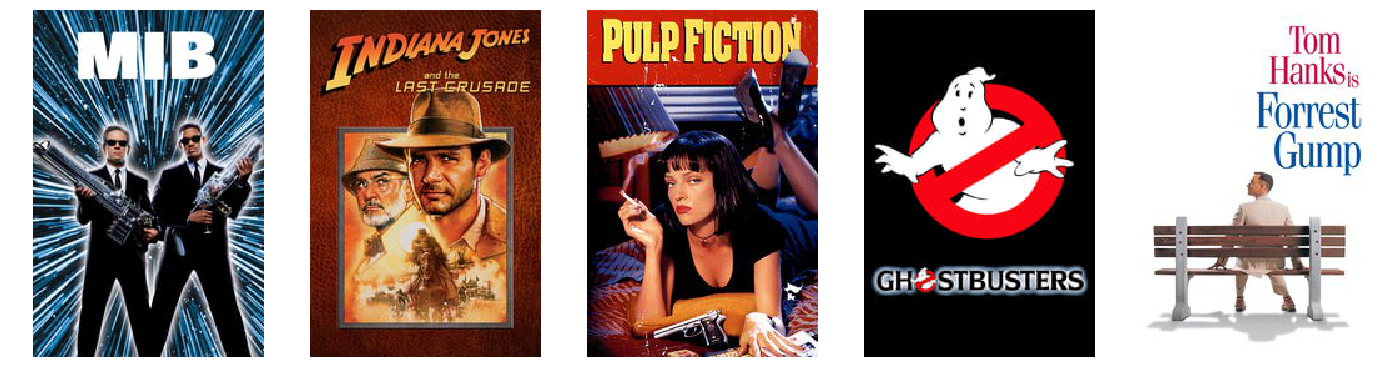

In [56]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
fig = figure(figsize=(24, 12))

for i in range (0,len(user3rec)):
    filename=user3rec['poster'].values[i]
    a=fig.add_subplot(1,len(user3rec),i+1)
    image = imread(filename)
    imshow(image)
    axis('off')

In the above model creation, we have found the top five highest ranking items for each user. Two users are shown with their corresponding highest ranking items (that they have not rated). Below are the list of the movies that user 3 watched and with rating he/she has given. As you can see this user gave highest rate to Drama/Romance/Adventure/Fantasy movies and our model recommended same type of movies.

In [57]:
user3 = mergedDF.loc[result.userId==3].sort_values(by='rating',ascending=False)
user3

,movieId,title,genres,poster,year,userId,tag,rating
366122,96821,"Perks of Being a Wallflower, The (2012)",Drama|Romance,ml-20m/posters/96821.jpg,2012,28599,touching,4.5
309810,69757,(500) Days of Summer (2009),Comedy|Drama|Romance,ml-20m/posters/69757.jpg,2009,115153,quirky,4.0
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,ml-20m/posters/1.jpg,1995,1644,Watched,3.5


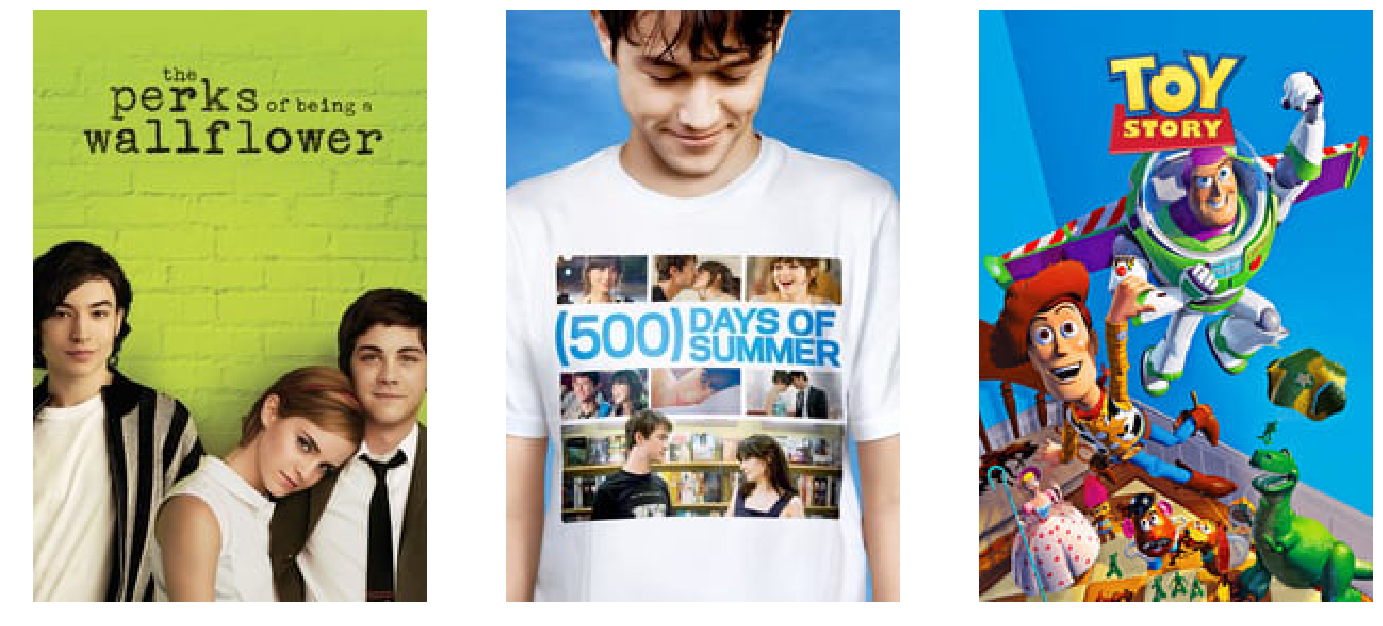

In [58]:
fig = figure(figsize=(24, 12))

for i in range (0,len(user3)):
    filename=user3['poster'].values[i]
    a=fig.add_subplot(1,len(user3),i+1)
    image = imread(filename)
    imshow(image)
    axis('off')

<a href="#top">Back to Top</a>
### Modeling and Evaluation - Summarize The Ramifications<a id="Modeling_and_Evaluation_Summarize_The_Ramifications"></a>
* Describe your results. What findings are the most interesting and why?

1. The model comparison results suggest that item_similarity recommender is a better fit for our dataset than ranking_factorization recommender. 

2. Using item_similarity recommender, we were able to achieve a mean precision at least 30% with recommendation items up to 7 movies. We noticed that the mean precision is at 42% when giving just one movie recommendation.  


<a href="#top">Back to Top</a>
### Deployment<a id="Deployment"></a>
* Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?
    - How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?
    - How would your deploy your model for interested parties?
    - What other data should be collected?
    - How often would the model need to be updated, etc.?

In online media companies, regular users are looking for ever improving personalized experiences. As they use the system more, the recommendations should become more specific and more accurate. when a new user comes to a site (cold starts) and we know nothing about them we can not give them good recommendations because our model does not have any history or preference for those users. there are some ways to make our recommended system useful such as request user to pick his/her preferences when signing up or rather than having a personalized system, we can collate the behavior of all users to make more general recommendations.

An recommended system will never be able to match User A to User B with perfect results, as their tastes will diverge at some point. If two users both rate 10 drama movies as good but differ in their opinion of the Comedy, they are still a very strong match.

in reality, recommendation systems don’t set a threshold when looking for compatibility between people; they look for the best possible match. If we have a user, Allen, who has a 95% compatibility with Chad, 80% with Ian, and 30% with Dave, the system will start by looking at Chad when deciding if Allen will like a certain movie. The more users we have in the data set, the more likely it is that a person with a high compatibility will give a response that the system can leverage.

After implementing our recommendation system it is important to make sure that it is working. One of the best approach to test our RS is A/B testing. By creating 2 different versions of our web page — one which utilizes our Recommendation System and one which does not — different customers see different versions of the website and we are able to observe which is more effective, by measuring how many of users watch movies that we recommended to them. We also can use this test to see how often our model need to be updated.


<a href="#top">Back to Top</a>
### Exceptional Work<a id="Exceptional_Work"></a>

## Creating a User-Item Matrices to find movies based on a single selection
### Using SVD (Singular-Value Decomposition) to reduce the matrix

#### Convert the Data to a User-Item Matrix

In [59]:
#import TruncatedSVD from sklearn
from sklearn.decomposition import TruncatedSVD

#convert the Data to a User-Item Matrix based on just the rating, userId and title data
#TruncatedSVD will not allow NULL so using the fill_value to produce 0 for the NULL
rating_pivot = mergedDF.pivot_table(values='rating', index='userId', columns='title', fill_value=0)
#looking at the first 5 entries
rating_pivot.head()

title,$9.99 (2008),'Salem's Lot (2004),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),(Untitled) (2009),*batteries not included (1987),+1 (2013),...And Justice for All (1979),1 (2013),...,[REC]³ 3 Génesis (2012),a/k/a Tommy Chong (2005),alaskaLand (2013),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nos amours (1983),Åsa-Nisse - Wälkom to Knohult (2011)
userId,,,,,,,,,,,,,,,,,,,,,
65,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0
96,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0
121,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0
129,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0
133,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0


We will need to transpose the matrix.

In [60]:
#looking at the shape of the matrix
rating_pivot.shape

(7159, 13390)

In [61]:
#transposing the rating_pivot using the T command
rating_transpose = rating_pivot.values.T

#check to see if things flipped
rating_transpose.shape

(13390L, 7159L)

#### Running SVD (Singular-Value Decomposition) to reduce the matrix

In [62]:
#using 12 components
rating_SVD = TruncatedSVD(n_components=12, random_state=42)
result_maxrix = rating_SVD.fit_transform(rating_transpose)
#looking at the shape of the smaller matrix
result_maxrix.shape

(13390L, 12L)

#### Create a Pearson's R Correlation for every movie
We can use this to compare one movie to others that someone may like based on user preferences.

In [63]:
result_corr = np.corrcoef(result_maxrix)
#looking at the shape
result_corr.shape

(13390L, 13390L)

#### Test the system on one of our favorite movies: The Shawshank Redemption

In [64]:
# create a movie names index
movie_names = rating_pivot.columns
movie_list = list(movie_names)

#pull the index number of the movie you want to find similarities too
Shawshank = movie_list.index('Shawshank Redemption, The (1994)')
#print out the index of our movie
print(Shawshank)

10572


#### Get the correlation result of our movie

In [65]:
corr_Shawshank = result_corr[Shawshank]
#This is shape of the Pearson's R Correlation for one movie.
#It shows 13390 results for this one movie. This is how it compares to all the others in the data set.
corr_Shawshank.shape

(13390L,)

In [66]:
corr_Shawshank

array([ 0.45512982, -0.21720439, -0.01794209, ...,  0.30875932,
        0.24424757,  0.00223445])

#### Finding highly correlated movies

In [67]:
#finding some of the top correlated movies to ours
list(movie_names[(corr_Shawshank < 1.0) & (corr_Shawshank > 0.9)])

['Beautiful Mind, A (2001)',
 'Forrest Gump (1994)',
 'Good Will Hunting (1997)',
 'Platoon (1986)',
 'Rain Man (1988)',
 "Schindler's List (1993)",
 'Shakespeare in Love (1998)',
 'Silence of the Lambs, The (1991)',
 'Sixth Sense, The (1999)']

In [68]:
#finding the highest correlated movie to ours
list(movie_names[(corr_Shawshank < 1.0) & (corr_Shawshank > 0.93)])

['Forrest Gump (1994)', 'Rain Man (1988)', 'Shakespeare in Love (1998)']

### Showing recommended movies posters

In [69]:
rating_movieId = mergedDF.pivot_table(values='rating', index='userId', columns='movieId', fill_value=0)
#transposing the rating_pivot using the T command
rating_transpose_movieId = rating_movieId.values.T
#Running SVD (Singular-Value Decomposition) to reduce the matrix
rating_SVD_movieId = TruncatedSVD(n_components=12, random_state=42)
result_maxrix_movieId = rating_SVD.fit_transform(rating_transpose_movieId)
#Create a Pearson's R Correlation for every movie
result_corr_movieId = np.corrcoef(result_maxrix_movieId)
# create a movie ID index
movie_Id = rating_movieId.columns
movieId_list = list(movie_Id)
#pull the index number of the movie you want to find similarities too
ShawshankId = movieId_list.index(mergedDF.loc[mergedDF['title']=='Shawshank Redemption, The (1994)']['movieId'].values[0])
#This is shape of the Pearson's R Correlation for one movie.
corr_ShawshankId = result_corr_movieId[ShawshankId]
corr_ShawshankId

array([ 0.70653048,  0.70076151,  0.35633654, ...,  0.26588546,
        0.35426222, -0.07679669])

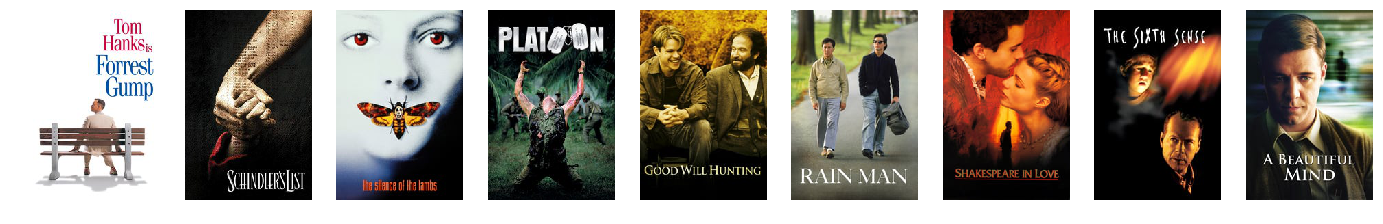

In [70]:
listId=movie_Id[(corr_ShawshankId < 1.0) & (corr_ShawshankId > 0.9)]

fig = figure(figsize=(24, 12))

for i in range (0,len(listId)):
    id = listId.values[i]
    filename='ml-20m/posters/'+str(id)+'.jpg'
    a=fig.add_subplot(1,len(listId),i+1)
    image = imread(filename)
    imshow(image)
    axis('off')